<a href="https://colab.research.google.com/github/gokullan/early-ARDS-prediction/blob/xgboost-trial/Early_Prediction_of_ARDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'fit-parity-376107' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Load data from BigQuery

In [141]:
table_id = 'fit-parity-376107.resultsdata.shape_final'
dataset = client.get_table(table_id)
# convert to Dataframe
dataset = client.list_rows(dataset).to_dataframe()

## Data Preprocessing and Visualization
For details on how the data was selected from the `mimiciv` database, please visit [this link](https://ards-prediction.atlassian.net/wiki/spaces/EPA/pages/393244/Queries) 

In [ ]:
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# display tabular data
dataset

,age,hadm_id,sub_id,stay_id,respiratory_rate_set,respiratory_rate_total,respiratory_rate_spontaneous,minute_volume,tidal_volume_set,tidal_volume_observed,...,metastatic_solid_tumor,aids,charlson_comorbidity_index,subject_id,hematocrit_1,hemoglobin_1,rbc,wbc,platelet,charttime
0,77,26184834,10001884,37510196,20.0,20.0,0.0,8.0,400.0,408.0,...,0,0,5,10001884,36.0,11.4,4.01,18.4,171.0,2131-01-11 06:31:00
1,77,26184834,10001884,37510196,NaN,15.0,15.0,6.7,NaN,395.0,...,0,0,5,10001884,33.6,10.4,3.68,12.0,149.0,2131-01-12 03:34:00
2,83,20345487,10002155,32358465,NaN,NaN,0.0,NaN,NaN,0.0,...,0,0,10,10002155,25.4,8.6,2.91,7.1,268.0,2131-03-10 04:25:00
3,81,28662225,10002428,38875437,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,6,10002428,34.8,10.7,3.46,10.5,175.0,2156-04-19 19:43:00
4,81,28662225,10002428,38875437,20.0,NaN,NaN,NaN,NaN,NaN,...,0,0,6,10002428,31.7,9.9,3.27,13.2,183.0,2156-04-20 03:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176224,21,29998399,18434803,39492012,22.0,22.0,0.0,9.2,430.0,425.0,...,0,0,0,18434803,24.9,9.1,2.94,8.5,70.0,2112-05-10 07:00:00
176225,76,29999098,15129243,33475199,17.0,29.0,0.0,15.4,400.0,514.0,...,0,0,4,15129243,NaN,NaN,NaN,NaN,52.0,2128-06-10 19:00:00
176226,69,29999625,10355856,36975675,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,5,10355856,44.6,14.2,4.95,12.5,218.0,2157-11-16 03:00:00
176227,69,29999625,10355856,36975675,12.0,14.0,14.0,6.0,450.0,430.0,...,0,0,5,10355856,44.6,14.2,4.95,12.5,218.0,2157-11-16 03:02:00


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176229 entries, 0 to 176228
Data columns (total 74 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   age                           176229 non-null  Int64         
 1   hadm_id                       176229 non-null  Int64         
 2   sub_id                        176229 non-null  Int64         
 3   stay_id                       176229 non-null  Int64         
 4   respiratory_rate_set          101450 non-null  float64       
 5   respiratory_rate_total        111830 non-null  float64       
 6   respiratory_rate_spontaneous  110431 non-null  float64       
 7   minute_volume                 119132 non-null  float64       
 8   tidal_volume_set              94000 non-null   float64       
 9   tidal_volume_observed         116187 non-null  float64       
 10  tidal_volume_spontaneous      30948 non-null   float64       
 11  plateau_press

### Remove irrelevant columns
These columns are **for sure** not required for the purposes of this task and are hence dropped before further manipulation.

In [142]:
cols_irrelevant = [
 'sub_id',
 'aado2',
 'aado2_calc',
 'fio2_chartevents',
 'baseexcess',
 'bicarbonate',
 'totalco2',
 'carboxyhemoglobin',
 'methemoglobin',
 'chloride',
 'subject_id'
]
dataset = dataset.drop(columns=cols_irrelevant, axis=1)

### Handle Non-Numeric Parameters

In [143]:
def get_non_numeric_cols(all_cols):
  num_cols = dataset._get_numeric_data().columns
  return dataset.drop(columns=num_cols, inplace=False).dtypes

get_non_numeric_cols(dataset.columns)

ventilator_mode            object
ventilator_type            object
temperature                object
specimen                   object
charttime          datetime64[ns]
dtype: object

In [144]:
# `temperature` should not be categorical => change to numeric type
dataset['temperature'] = pd.to_numeric(dataset['temperature'])

In [145]:
categorical_cols = [
    'specimen',
    'ventilator_type',
    'ventilator_mode'
]

#### Visualize Categorical Data

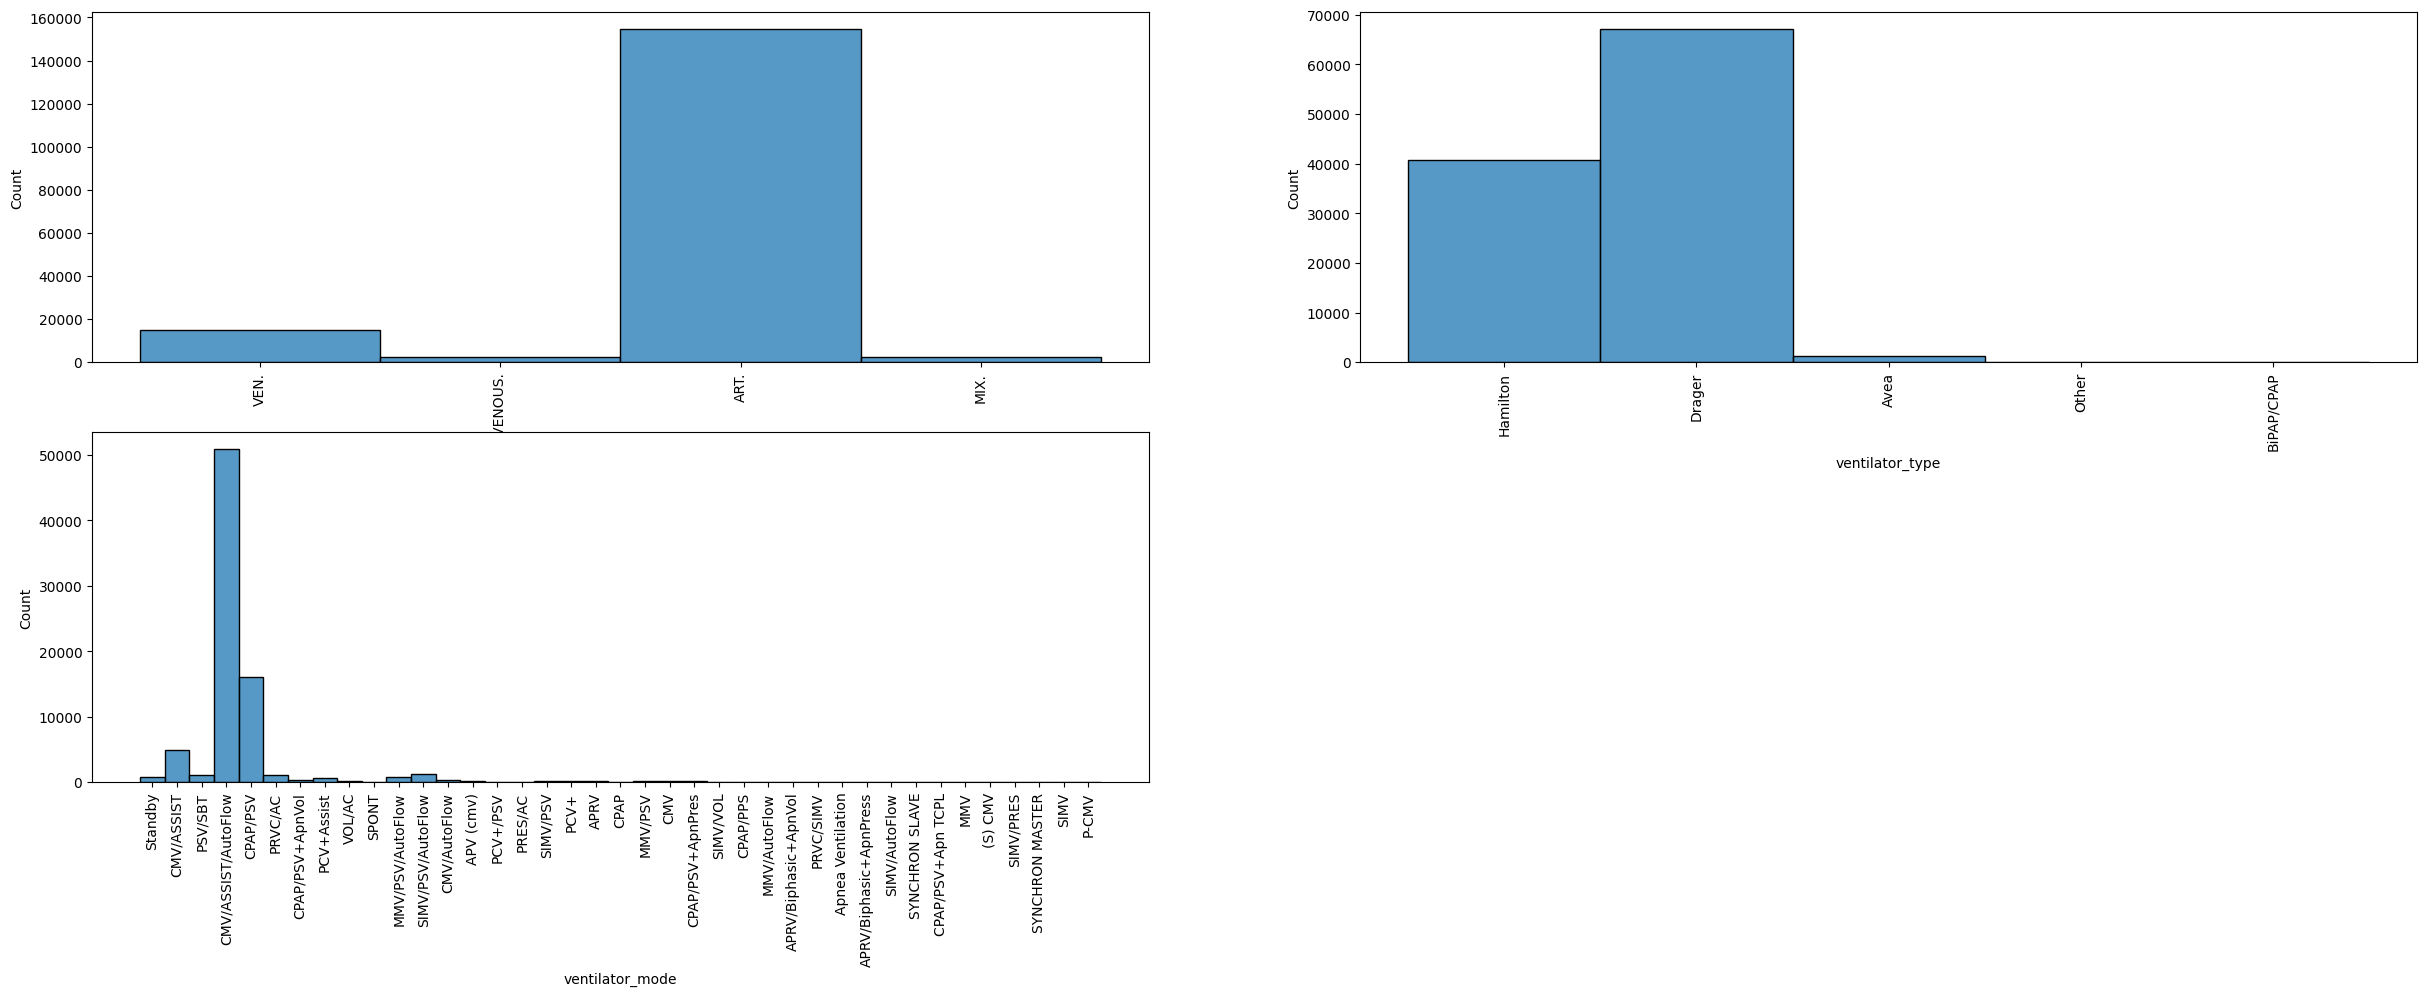

In [146]:
m = len(categorical_cols)

f, axes = plt.subplots(math.ceil(m / 2), 2, figsize=(30, 10))
axes = axes.ravel()

for num in range(m):
  sns.histplot(dataset[categorical_cols[num]], ax=axes[num])
  axes[num].set_xticks(axes[num].get_xticks())
  axes[num].set_xticklabels(
    labels=axes[num].get_xticklabels(),
    rotation=90
  )
# plt.tight_layout()

for num in range(m, len(axes)):
  axes[num].set_visible(False)

#### Preprocess based on visuals

In [147]:
# set all values apart from `Hamilton`, `Drager` and `Avea` to `Other`
dataset['ventilator_type'].replace(
    to_replace=['BiPAP/CPAP', 'Sensor Medic (HFO)', 'PB 7200'],
    value='Other',
    inplace=True
)
# drop `ventilator_mode` due on account of too many values
dataset.drop(columns=['ventilator_mode'], axis=1, inplace=True)

In [148]:
categorical_cols = [
    'specimen',
    'ventilator_type',
]
# these will be OneHotEncoded later

## Inspect Null Values

<Axes: >

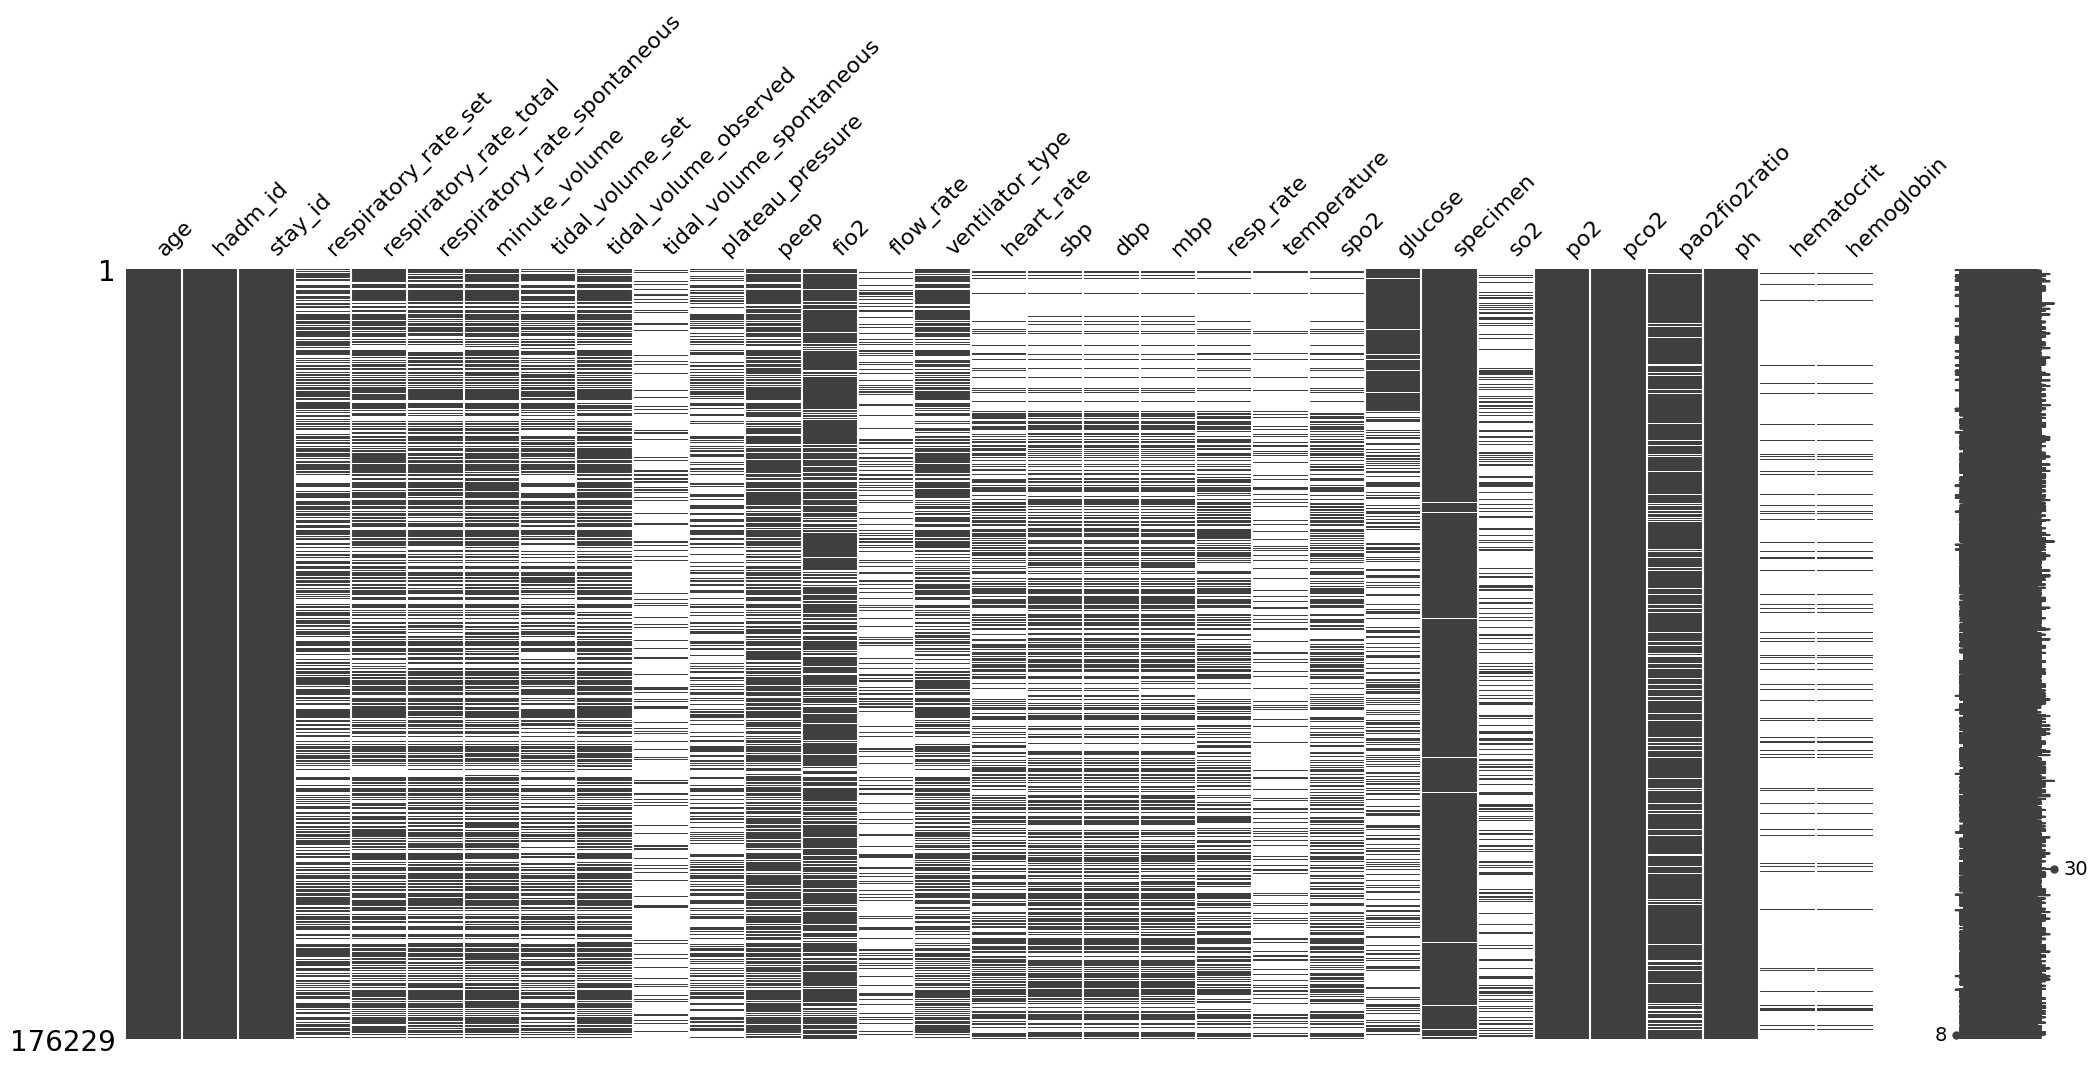

In [149]:
import missingno as msno

n_cols = len(dataset.columns)
msno.matrix(dataset[dataset.columns[:n_cols // 2]])

<Axes: >

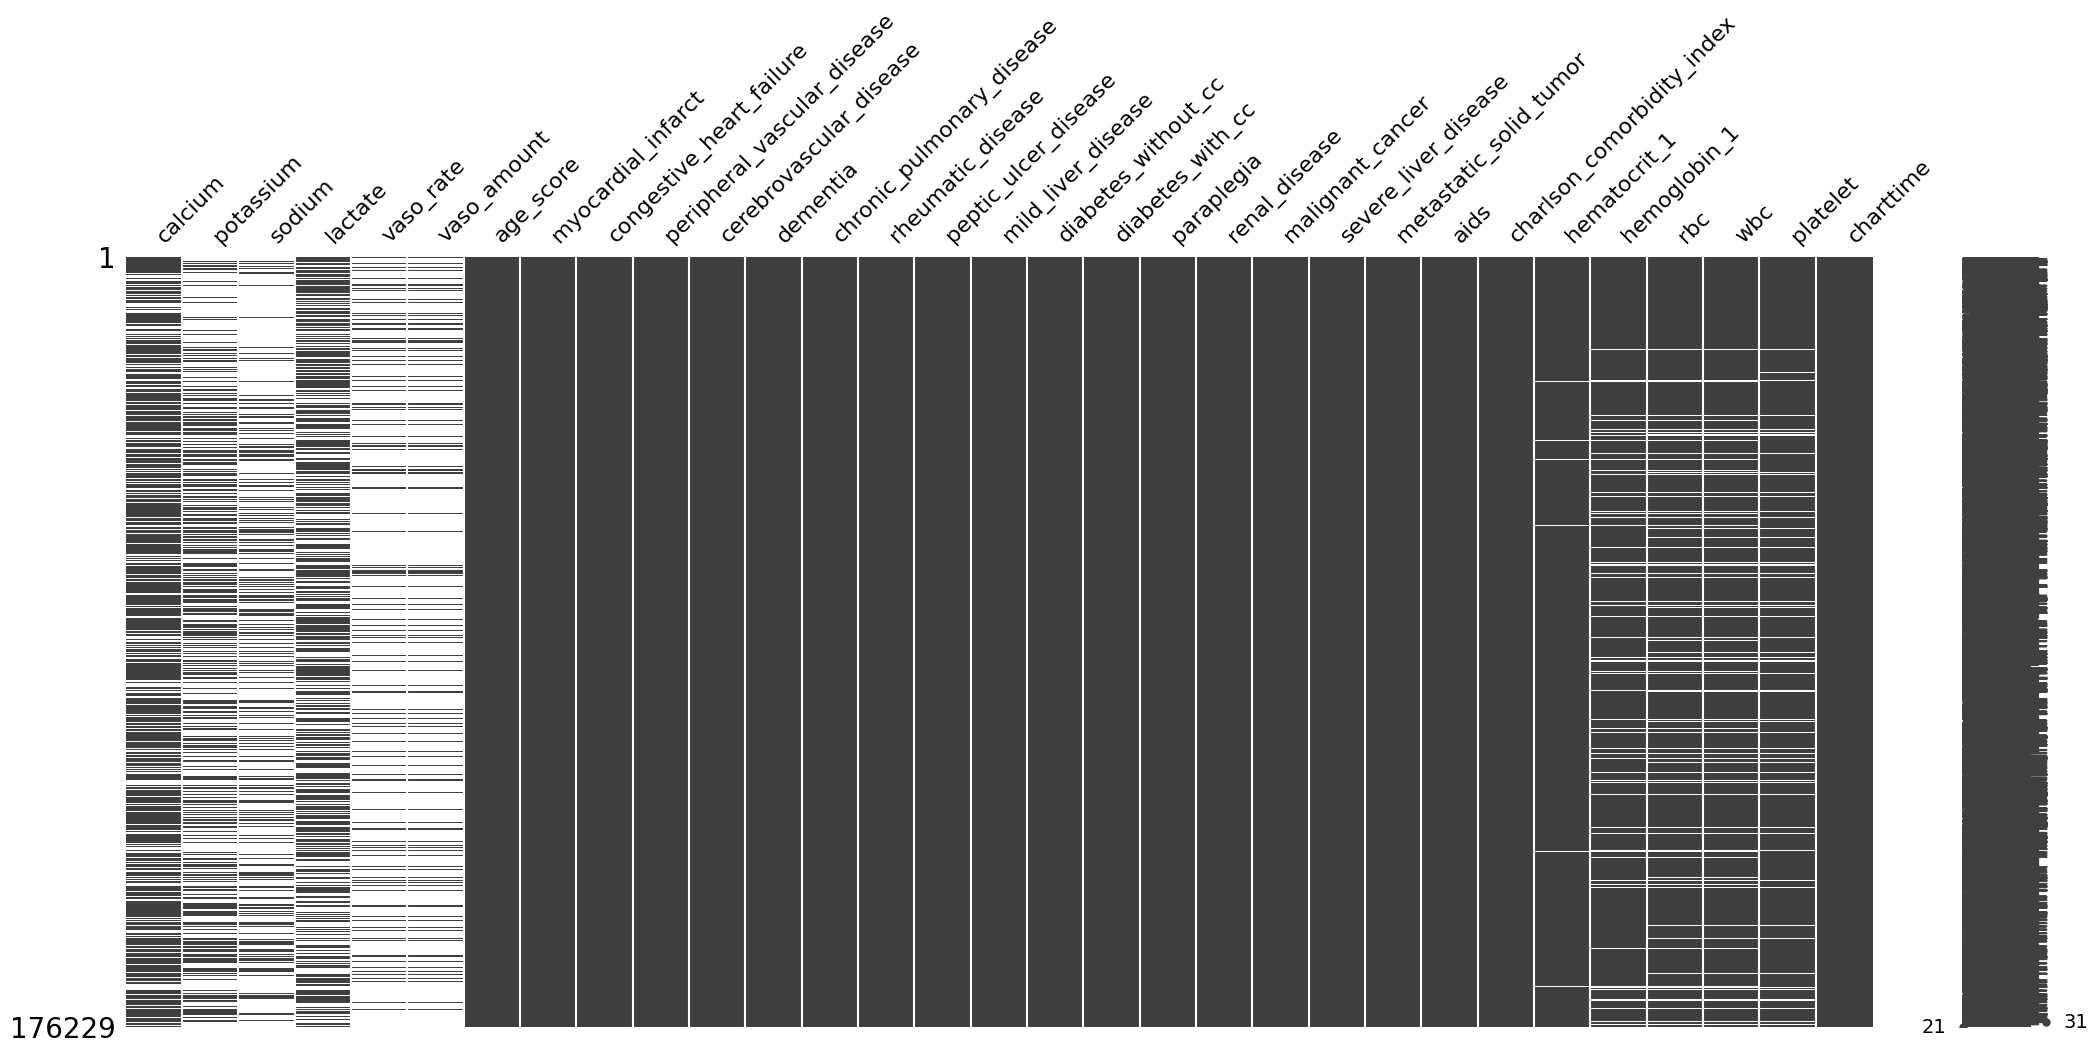

In [150]:
msno.matrix(dataset[dataset.columns[n_cols // 2:]])


### Drop some columns

In [151]:
n = len(dataset)
# cols_to_drop = null_data[null_data['Count'] > 0.5 * n]['Parameter'].values
cols_to_drop = [
    'respiratory_rate_spontaneous',
    'tidal_volume_spontaneous',
    'flow_rate',
    'hemoglobin',
    'hematocrit',

]
dataset = dataset.drop(columns=cols_to_drop, axis=1)

#### Fill missing values using 'forward fill' method

In [ ]:
dataset = dataset.fillna(method='ffill')

## Correlation Matrix

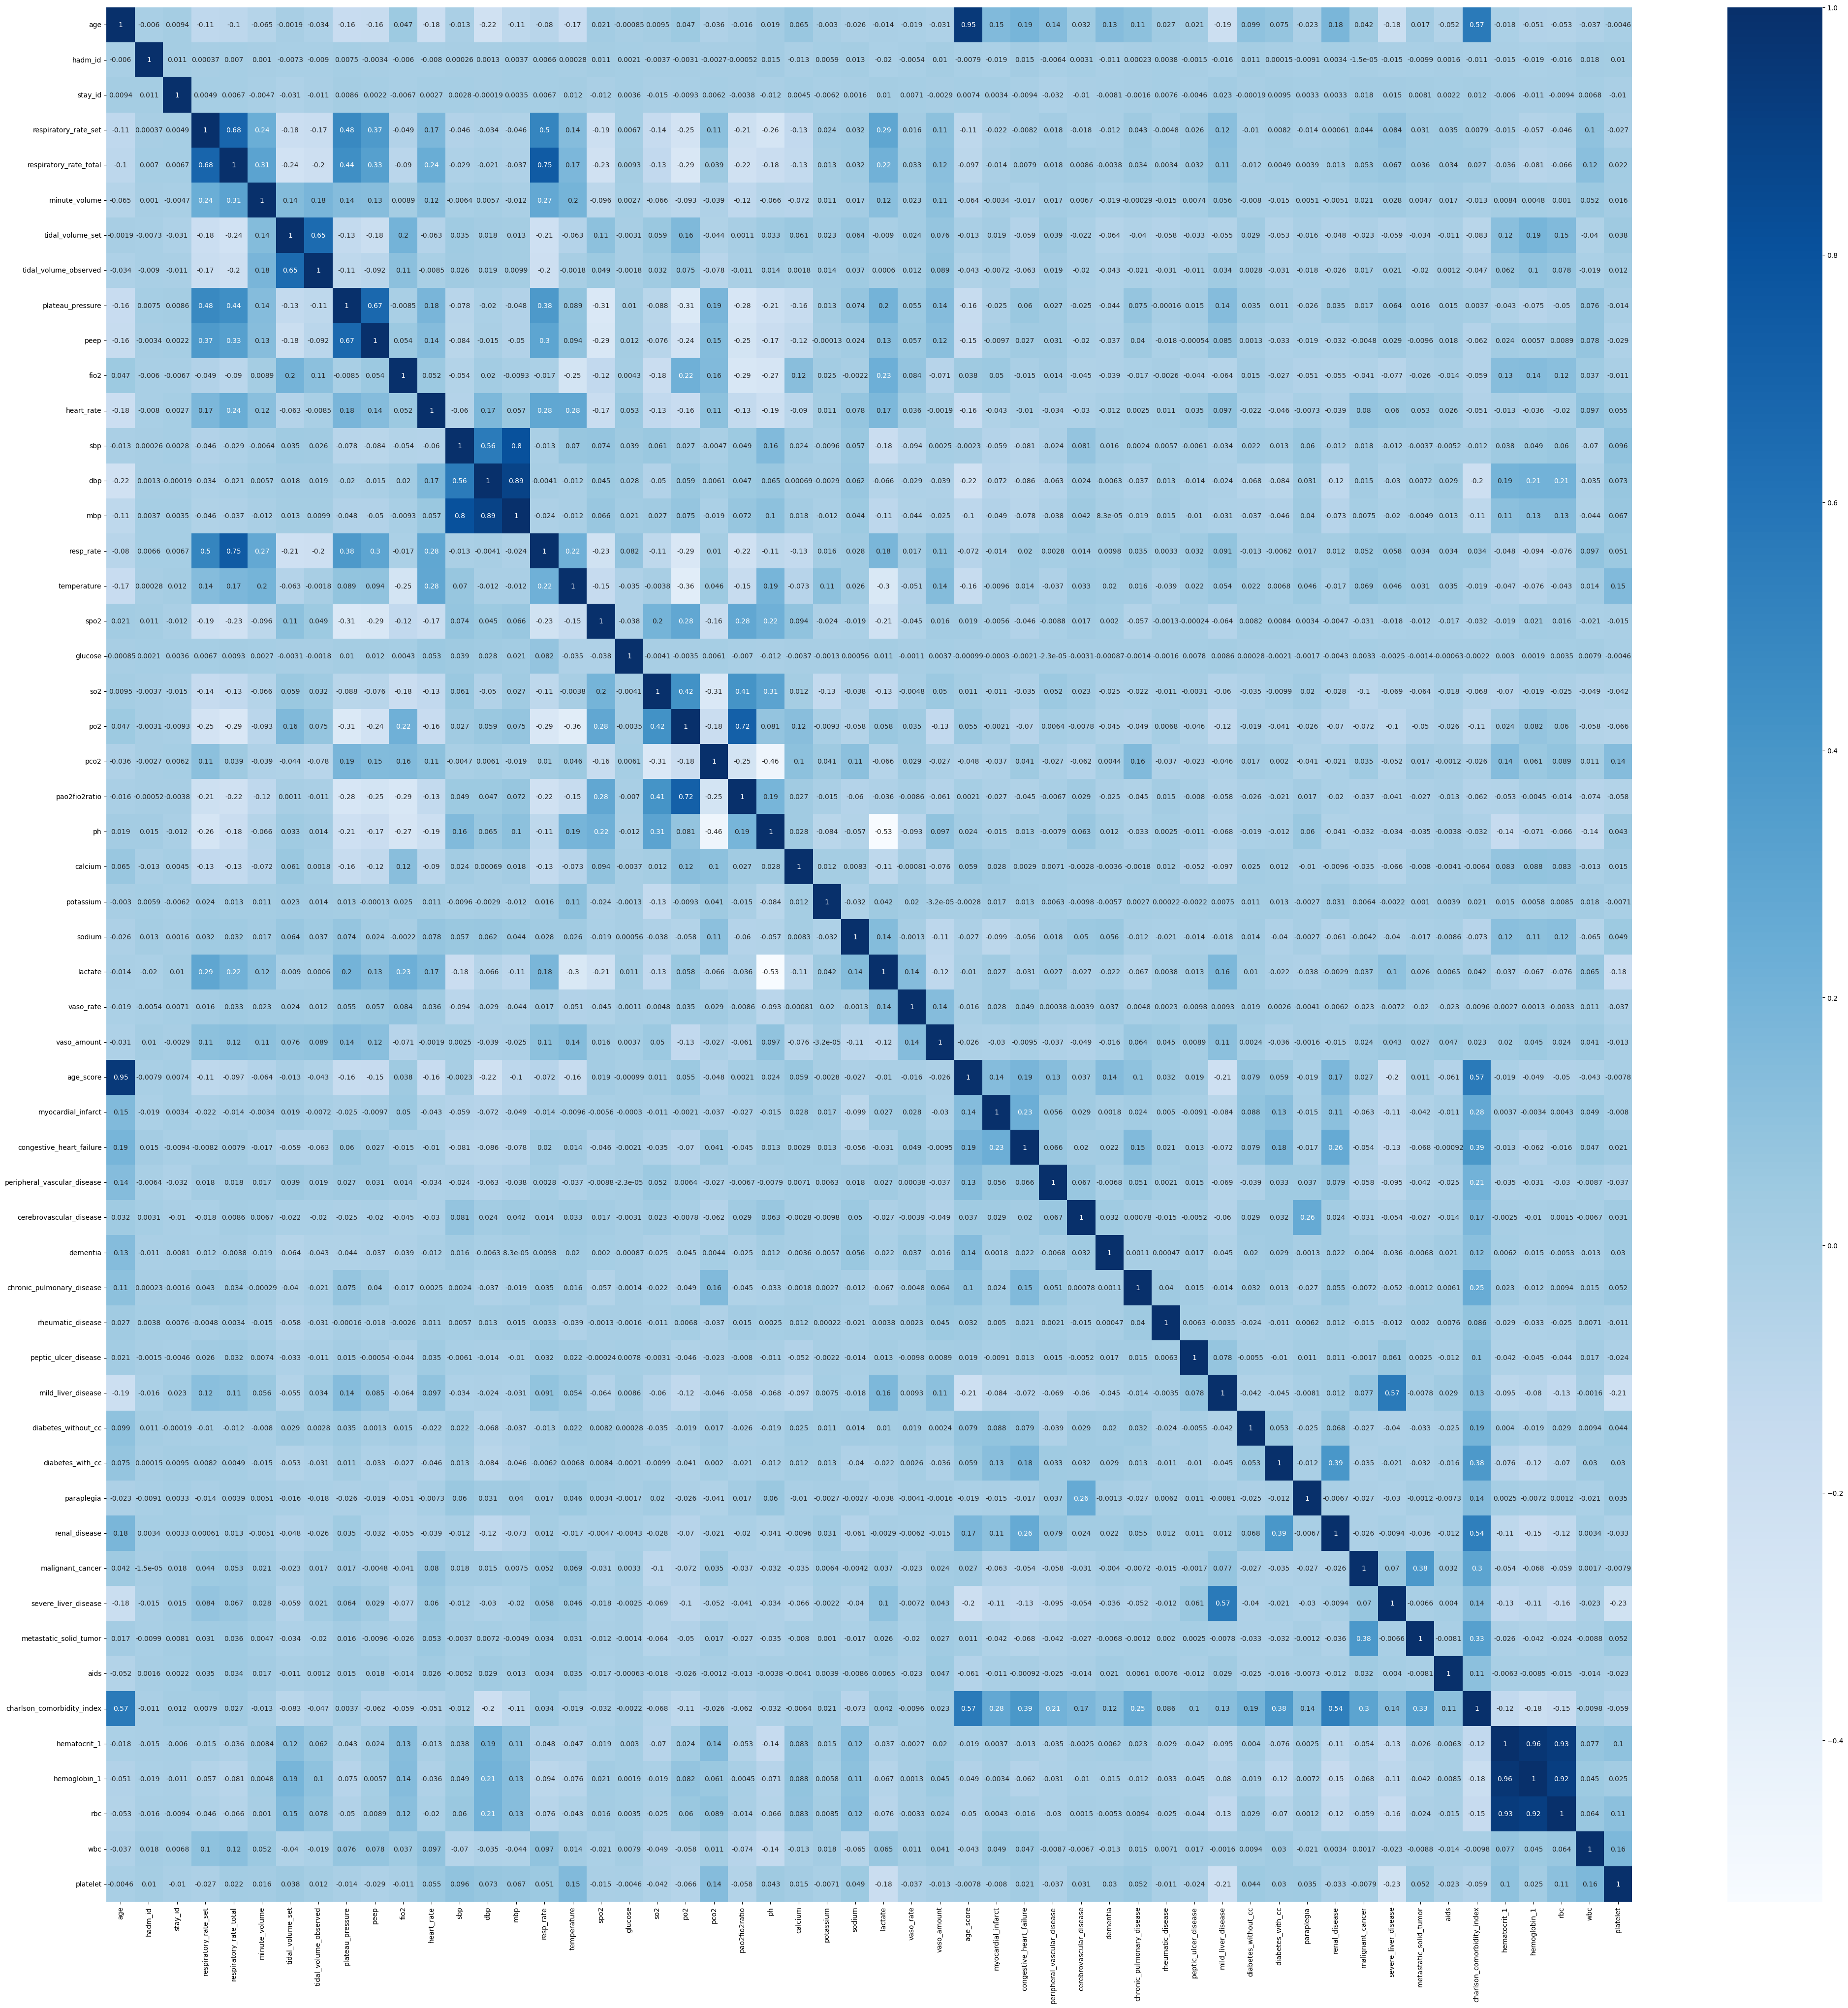

In [152]:
def plot_corr_map(df):
  corr_matrix = df._get_numeric_data().corr()
  plt.figure(figsize=(50, 50))
  sns.heatmap(corr_matrix, annot=True, cmap="Blues")
  plt.show()

plot_corr_map(dataset)

In [153]:
cols_to_drop = [
    'respiratory_rate_set',
    'respiratory_rate_total',
    'plateau_pressure',
    'po2',
    'sbp',
    'dbp',
    'charlson_comorbidity_index',
    'hemoglobin_1',
    'hematocrit_1',
    'age_score'
]
dataset.drop(columns=cols_to_drop, axis=1, inplace=True)

## One-Hot-Encode the categorical values

In [154]:
samples_all = dataset
for col in categorical_cols:
  samples_all = pd.concat(
      [
        samples_all,
        pd.get_dummies(dataset[col])
      ],
      axis=1
  )
  samples_all.drop(columns=[col], inplace=True)

## Order all samples by their `stay_id`s, then by their `charttime`s

In [177]:
samples_grouped = samples_all.groupby(by='stay_id')
grouped_and_sorted = []
for name, group in samples_grouped.__iter__():
  # consider only those records that have at least 10 samples
  if (len(group) > 10):
    grouped_and_sorted.append(group.sort_values(by='charttime').reset_index(drop=True))

## Fill Null Values

In [178]:
cols = grouped_and_sorted[0].columns
for idx in range(len(grouped_and_sorted)):
  _n = len(group)
  for col in cols:
    if grouped_and_sorted[idx][col].isna().sum() == _n:
      grouped_and_sorted[idx][col].fillna(0, inplace=True)
    else:
      grouped_and_sorted[idx][col].fillna(method='ffill', inplace=True)
      grouped_and_sorted[idx][col].fillna(method='bfill', inplace=True)

## Handle outliers

In [179]:
groups_combined = grouped_and_sorted[0]
for idx in range(1, len(grouped_and_sorted)):
  groups_combined = pd.concat(
      [
       groups_combined,
       grouped_and_sorted[idx]
      ],
      axis=0
  )

In [180]:
def display_box_plot(dataset, cols, exclude=[]):
  n = len(cols)
  rows = math.ceil(n / 3)
  plot_count = 1
  plt.figure(figsize=(30, 5 * rows))
  for idx in range(n):
    if cols[idx] in exclude:
      continue
    data = dataset[cols[idx]].dropna().values
    plt.subplot(rows, 3, plot_count)
    plt.boxplot(data)
    plt.title(cols[idx], fontsize=20)
    plot_count += 1
  plt.tight_layout()

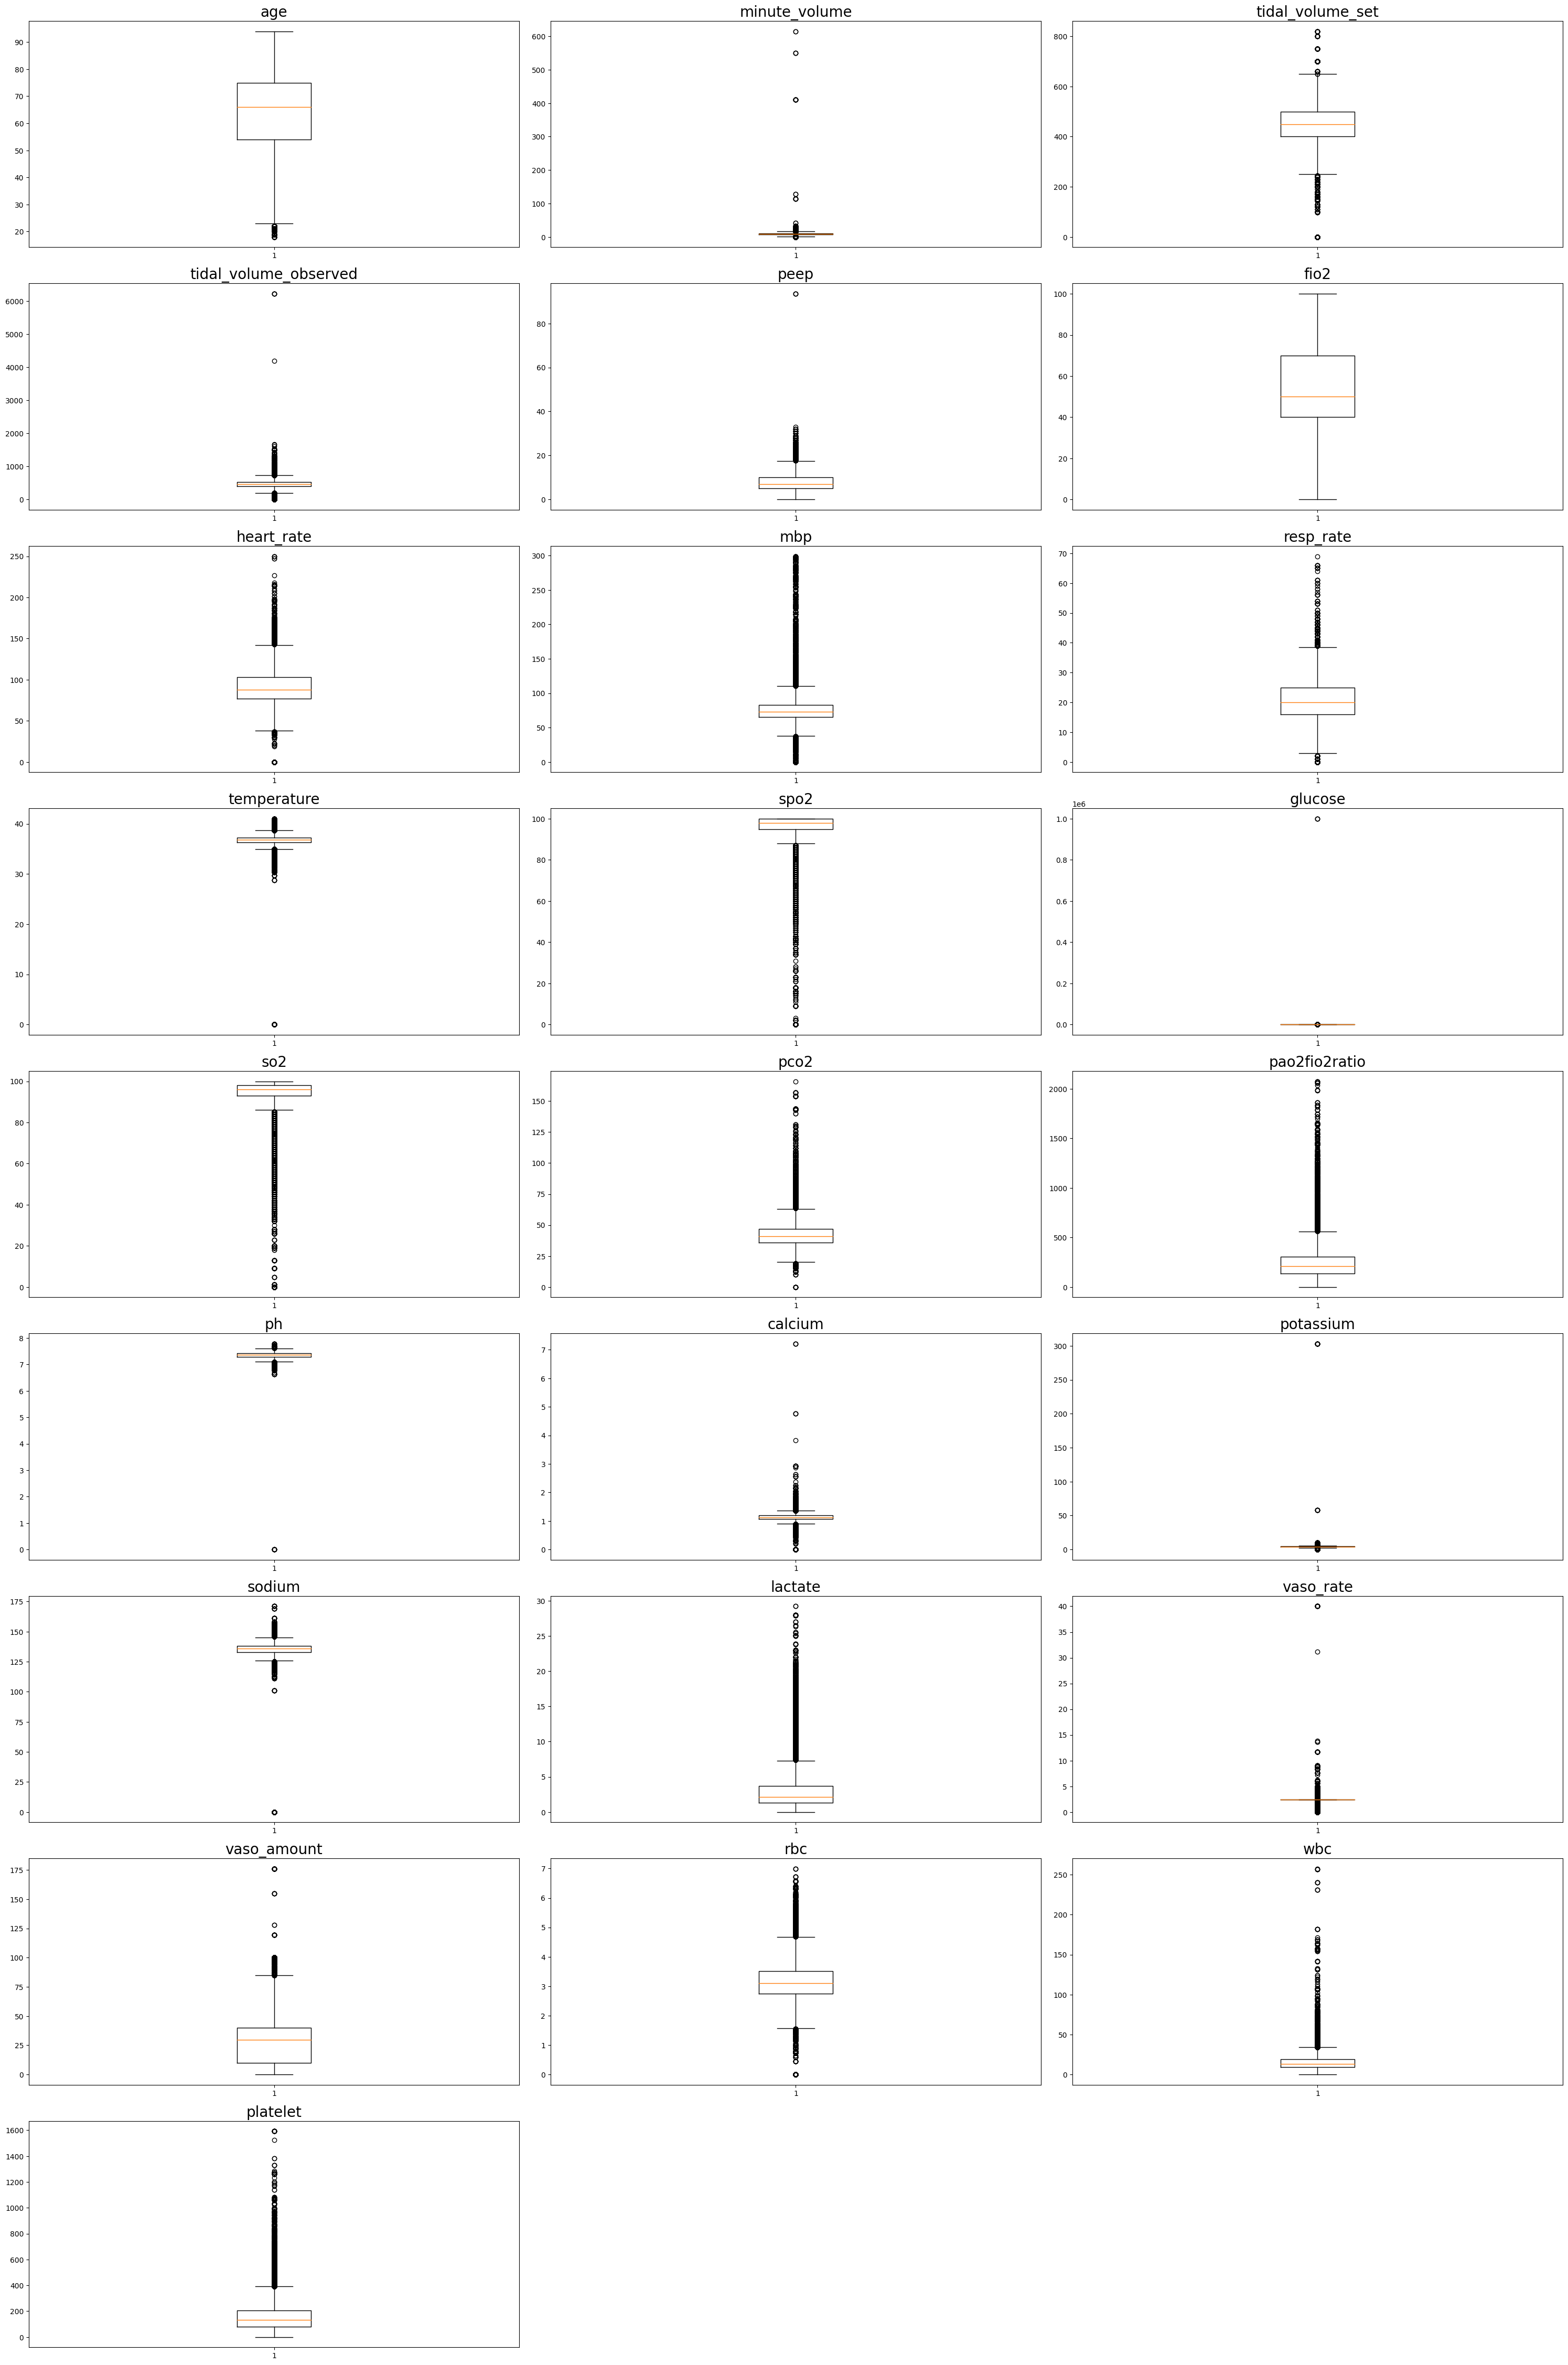

In [181]:
to_exclude = [
     'ART.', 'CENTRAL VENOUS.', 'MIX.', 'VEN.', 
     'Avea', 'Drager', 'Hamilton', 'Other',
     'hadm_id', 'stay_id', 'myocardial_infarct', 
     'congestive_heart_failure', 'peripheral_vascular_disease',
     'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
     'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
     'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
     'renal_disease', 'malignant_cancer', 'severe_liver_disease',
     'metastatic_solid_tumor', 'aids'
]
display_box_plot(
    groups_combined,
    groups_combined._get_numeric_data().columns,
    to_exclude
)

In [172]:
def remove_outliers(colname):
  Q1 = np.percentile(groups_combined[colname], 20,
                   method = 'midpoint')
  Q3 = np.percentile(groups_combined[colname], 80,
                    method = 'midpoint')
  IQR = Q3 - Q1
  print("Q1 = {}, Q3 = {}".format(Q1, Q3))
  
  # Upper bound
  upper = Q3 + 1.5 * IQR
  upper_array = np.where(groups_combined[colname]>upper)
  # Lower bound
  lower = Q1 - 1.5 * IQR
  lower_array=np.where(groups_combined[colname]<=lower)

  # Removing the outliers
  # groups_combined.drop(upper_array[0],inplace=True)
  groups_combined.loc[upper_array[0], colname] = IQR
  groups_combined.loc[lower_array[0], colname] = IQR

In [183]:
for colname in groups_combined._get_numeric_data().columns:
  if colname in to_exclude or colname == 'age':
    continue
  else:
    remove_outliers(colname)

Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = nan, Q3 = nan
Q1 = 35.0, Q3 = 49.0


KeyError: ignored

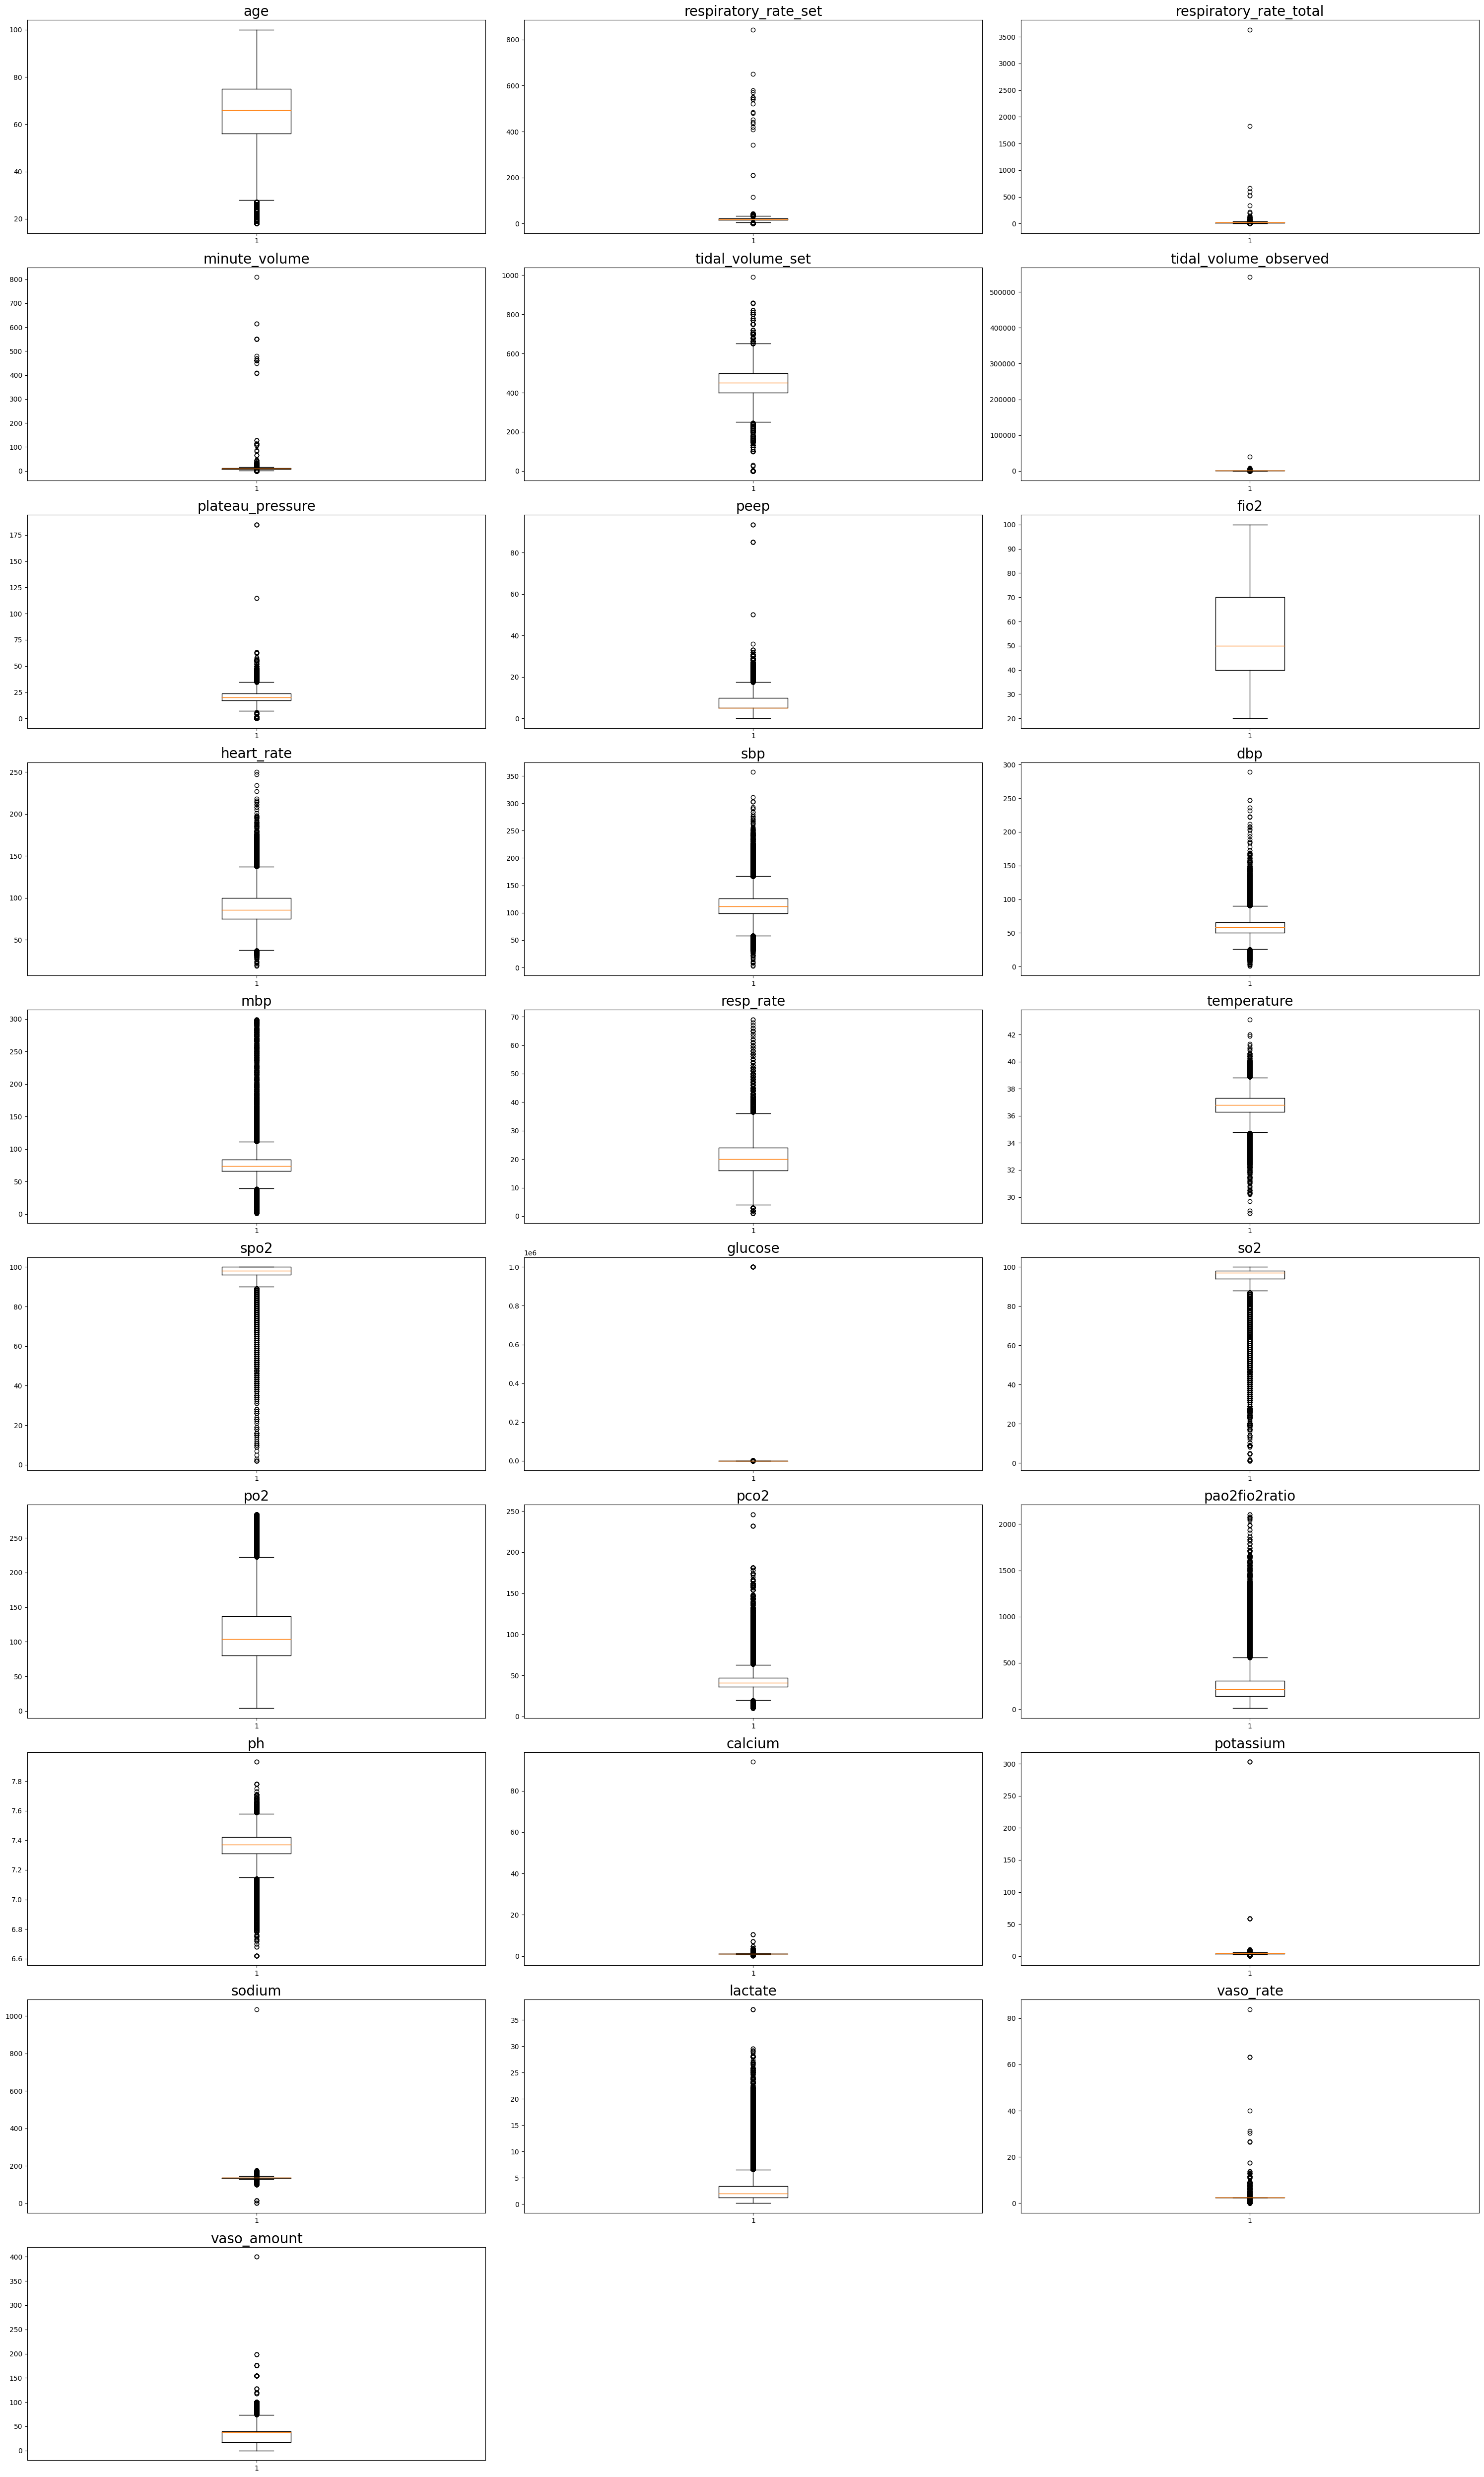

In [ ]:
# visualize box-plots after removal of outliers
display_box_plot(dataset._get_numeric_data().columns)

In [197]:
groups_combined.isna().sum()

age                                0
hadm_id                            0
stay_id                            0
minute_volume                    740
tidal_volume_set                1975
tidal_volume_observed            862
peep                             401
fio2                             134
heart_rate                        85
mbp                               85
resp_rate                         85
temperature                    14736
spo2                             270
glucose                          277
so2                            18115
pco2                               0
pao2fio2ratio                    217
ph                                 0
calcium                         2386
potassium                      18680
sodium                         33810
lactate                         1089
vaso_rate                      44452
vaso_amount                    44452
myocardial_infarct                 0
congestive_heart_failure           0
peripheral_vascular_disease        0
c

## Feature Selection

In [ ]:
cols_selected = ['tidal_volume_observed', 'pao2fio2ratio', 'platelet', 'rbc',
       'temperature', 'glucose', 'wbc', 'age', 'vaso_amount', 'minute_volume',
       'heart_rate', 'mbp', 'tidal_volume_set', 'lactate', 'vaso_rate',
       'resp_rate', 'potassium', 'calcium', 'pco2', 'ph', 'peep', 'charttime', 'hadm_id', 'stay_id']
for idx in range(len(grouped_and_sorted)):
  grouped_and_sorted[idx] = grouped_and_sorted[idx][cols_selected]

## Prepare the training set

In [ ]:
def find_onset_time(stay):
  idx = 0
  for index, row in stay.iterrows():
    if row['peep'] >= 5 and row['pao2fio2ratio'] < 300:
      return idx
    idx += 1
  return -1

In [ ]:
def do_resampling(df):
  df = df.set_index('charttime')
  df = df.resample('120min').median()  
  return df.fillna(method='ffill')

In [184]:
for idx in range(len(grouped_and_sorted)):
  grouped_and_sorted[idx] = do_resampling(grouped_and_sorted[idx])
  grouped_and_sorted[idx].drop(columns=['hadm_id', 'stay_id'], inplace=True)

In [ ]:
# returns the (integer) hours difference between the 2 timestamps 
def hours_diff(t1, t2):
  diff = math.floor(
      (t2 - t1).total_seconds() / 3600
  )
  return diff

In [ ]:
def make_samples(pred_window=12, bound=48):
  positive = []
  negative = []
  count = 0
  for group in grouped_and_sorted:
    onset_time_index = find_onset_time(group)
    if onset_time_index != -1:
      onset_time = group.index[onset_time_index]
      # number of hours before the onset time for which data is available
      n_hours = hours_diff(group.index[0], group.index[onset_time_index])
      start = 0
      if n_hours > bound:
        start = (n_hours - bound) // 2
      if (onset_time_index - start + 1) > pred_window / 2:
        end_negative = (onset_time_index - start + 1) - pred_window // 2
        negative.append(group.iloc[start:end_negative])
        start = end_negative
      positive.append(group.iloc[start:onset_time_index])
    else:
      negative.append(group)
  print("{} {}".format(len(positive), len(negative)))
  return positive, negative

In [ ]:
def make_rnn_samples(samples, lookback):
  rnn_samples = []
  for sample in samples:
    n = len(sample)
    for i in range(n - lookback):
      rnn_samples.append(sample.iloc[i: i + lookback])
  return rnn_samples

In [185]:
positive, negative = make_samples(12)

positives_ = positive
negatives_ = negative

lookback = 3
positive_rnn = make_rnn_samples(positives_, lookback)
negative_rnn = make_rnn_samples(negatives_, lookback)
print("No. of positive samples: {}".format(len(positive_rnn)))
print("No. of negative samples: {}".format(len(negative_rnn)))

3838 863
No. of positive samples: 9871
No. of negative samples: 9152


In [186]:
rnn_samples_all = positive_rnn + negative_rnn
labels_all = [1 for i in range(len(positive_rnn))] + [0 for i in range(len(negative_rnn))]

## Get training records

In [187]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X, y = shuffle(rnn_samples_all, labels_all)

In [188]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
X_train_s = np.array([scalar.fit_transform(x) for x in X_train]).astype(np.float32)
X_test_s = np.array([scalar.fit_transform(x) for x in X_test]).astype(np.float32)

In [ ]:
y_train = np.array(y_train).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [ ]:
# parameters
n_inputs = X_train[0].shape[1]  # number of features
n_neurons = 50
n_outputs = 2
n_layers = 2
batch_size = 28
n_epochs = 25

## RNN

In [ ]:
class RNNModel:
  def __init__(self):
    pass

In [ ]:
RNNcells = [tf.keras.layers.SimpleRNNCell(n_neurons) for _ in range(n_layers)]
rnn = tf.keras.layers.StackedRNNCells(RNNcells, input_shape = (5, n_inputs))
RNNmodel = Sequential()
RNNmodel.add(layers.RNN(rnn))
RNNmodel.add(layers.Dense(64, activation='relu'))
RNNmodel.add(layers.Dense(n_outputs, activation='softmax'))

In [ ]:
RNNmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
RNNhistory=RNNmodel.fit(
    X_train_s,
    y_train,
    validation_data=(X_test_s, y_test), 
    batch_size=batch_size, 
    epochs=n_epochs,
)

Epoch 1/25
397/397 [==============================] - 4s 6ms/step - loss: 0.6727 - accuracy: 0.6061 - val_loss: 0.6600 - val_accuracy: 0.6227
Epoch 2/25
397/397 [==============================] - 2s 6ms/step - loss: 0.6609 - accuracy: 0.6199 - val_loss: 0.6604 - val_accuracy: 0.6223
Epoch 3/25
397/397 [==============================] - 3s 6ms/step - loss: 0.6535 - accuracy: 0.6268 - val_loss: 0.6626 - val_accuracy: 0.6248
Epoch 4/25
397/397 [==============================] - 3s 7ms/step - loss: 0.6447 - accuracy: 0.6341 - val_loss: 0.6639 - val_accuracy: 0.6232
Epoch 5/25
397/397 [==============================] - 2s 5ms/step - loss: 0.6356 - accuracy: 0.6413 - val_loss: 0.6701 - val_accuracy: 0.6242
Epoch 6/25
397/397 [==============================] - 2s 5ms/step - loss: 0.6281 - accuracy: 0.6467 - val_loss: 0.6624 - val_accuracy: 0.6225
Epoch 7/25
397/397 [==============================] - 2s 5ms/step - loss: 0.6191 - accuracy: 0.6501 - val_loss: 0.6713 - val_accuracy: 0.6269
Epoch 

###Hyper Parameter Tuning

In [ ]:
!pip install keras-tuner
import kerastuner as kt
def model_builder(hp):
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten((5, n_inputs)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))

  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='khyperband')
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_s, y_train, epochs=10, validation_split=0.2)
best_hp=tuner.get_best_hyperparameters()[0]


Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
256               |352               |units
0.0001            |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 155, in _try_build
    model = self._bui

RuntimeError: ignored

## LSTM

In [ ]:
LSTMcells = [tf.keras.layers.LSTMCell(n_neurons) for _ in range(n_layers)]
lstm = tf.keras.layers.StackedRNNCells(LSTMcells, input_shape = (5, n_inputs))
LSTMmodel = Sequential()
LSTMmodel.add(layers.RNN(lstm))
LSTMmodel.add(layers.Dense(64, activation='relu'))
LSTMmodel.add(layers.Dense(n_outputs, activation='softmax'))

In [ ]:
LSTMmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )


In [ ]:
LSTMhistory = LSTMmodel.fit(
    X_train_s,
    y_train,
    validation_data=(X_test_s, y_test), 
    batch_size=batch_size, 
    epochs=n_epochs,
)

Epoch 1/25
397/397 [==============================] - 8s 14ms/step - loss: 0.6692 - accuracy: 0.6055 - val_loss: 0.6689 - val_accuracy: 0.6084
Epoch 2/25
397/397 [==============================] - 6s 14ms/step - loss: 0.6617 - accuracy: 0.6185 - val_loss: 0.6583 - val_accuracy: 0.6240
Epoch 3/25
397/397 [==============================] - 4s 10ms/step - loss: 0.6557 - accuracy: 0.6223 - val_loss: 0.6549 - val_accuracy: 0.6263
Epoch 4/25
397/397 [==============================] - 5s 12ms/step - loss: 0.6492 - accuracy: 0.6286 - val_loss: 0.6555 - val_accuracy: 0.6299
Epoch 5/25
397/397 [==============================] - 4s 9ms/step - loss: 0.6413 - accuracy: 0.6355 - val_loss: 0.6574 - val_accuracy: 0.6261
Epoch 6/25
397/397 [==============================] - 4s 10ms/step - loss: 0.6320 - accuracy: 0.6406 - val_loss: 0.6588 - val_accuracy: 0.6345
Epoch 7/25
397/397 [==============================] - 5s 13ms/step - loss: 0.6207 - accuracy: 0.6477 - val_loss: 0.6477 - val_accuracy: 0.6383


## GRU

In [ ]:
GRUcells = [tf.keras.layers.GRUCell(n_neurons) for _ in range(n_layers)]
gru = tf.keras.layers.StackedRNNCells(GRUcells, input_shape = (5, n_inputs))
GRUmodel = Sequential()
GRUmodel.add(layers.RNN(gru))
GRUmodel.add(layers.Dense(64, activation='relu'))
GRUmodel.add(layers.Dense(n_outputs, activation='softmax'))

In [ ]:
GRUmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
GRUhistory = GRUmodel.fit(
    X_train_s,
    y_train,
    validation_data=(X_test_s, y_test), 
    batch_size=batch_size, 
    epochs=n_epochs,
)

Epoch 1/25
397/397 [==============================] - 7s 11ms/step - loss: 0.6698 - accuracy: 0.6049 - val_loss: 0.6616 - val_accuracy: 0.6221
Epoch 2/25
397/397 [==============================] - 5s 13ms/step - loss: 0.6611 - accuracy: 0.6183 - val_loss: 0.6601 - val_accuracy: 0.6208
Epoch 3/25
397/397 [==============================] - 4s 10ms/step - loss: 0.6548 - accuracy: 0.6229 - val_loss: 0.6673 - val_accuracy: 0.6272
Epoch 4/25
397/397 [==============================] - 4s 9ms/step - loss: 0.6486 - accuracy: 0.6308 - val_loss: 0.6659 - val_accuracy: 0.6223
Epoch 5/25
397/397 [==============================] - 5s 13ms/step - loss: 0.6408 - accuracy: 0.6356 - val_loss: 0.6578 - val_accuracy: 0.6217
Epoch 6/25
397/397 [==============================] - 4s 9ms/step - loss: 0.6298 - accuracy: 0.6454 - val_loss: 0.6534 - val_accuracy: 0.6366
Epoch 7/25
397/397 [==============================] - 4s 9ms/step - loss: 0.6189 - accuracy: 0.6523 - val_loss: 0.6579 - val_accuracy: 0.6307
Ep

## t-SNE Plot

In [ ]:
np.array(X_train).shape

(11335, 6, 29)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250)
tsne_pca_results = tsne.fit_transform(np.array(X_train).reshape(9770, 27*5))

ValueError: ignored

In [ ]:
tsne_df = pd.DataFrame(tsne_pca_results, columns=["tsne-2d-one", "tsne-2d-two"])

In [ ]:
tsne_df["y"] = y_train

In [ ]:
# plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

## Accuracy Plots

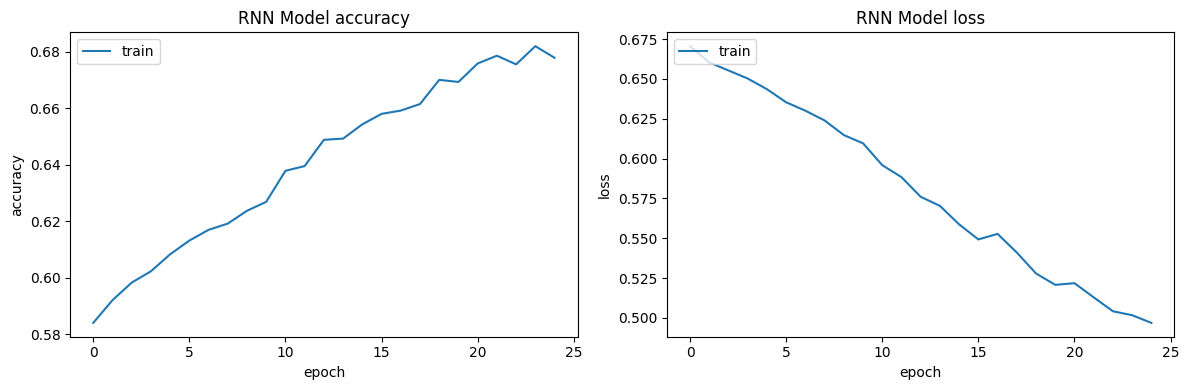

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
#plt.figure(figsize=(6,3))
plt.plot(RNNhistory.history['accuracy'])
plt.title('RNN Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.subplot(1,2,2)
#plt.figure(figsize=(6,3))
plt.plot(RNNhistory.history['loss'])
plt.title('RNN Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.tight_layout()

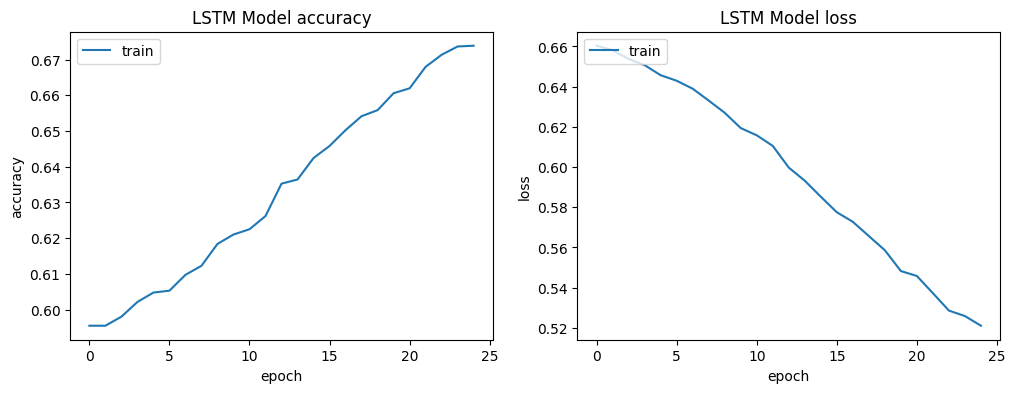

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(LSTMhistory.history['accuracy'])
plt.title('LSTM Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(LSTMhistory.history['loss'])
plt.title('LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

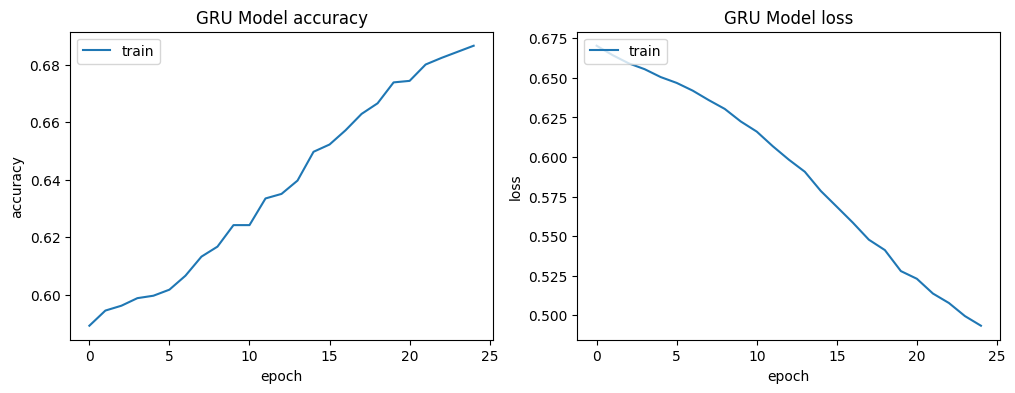

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(GRUhistory.history['accuracy'])
plt.title('GRU Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(GRUhistory.history['loss'])
plt.title('GRU Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')


## Transformers

In [ ]:
from tensorflow import keras

In [ ]:
n_classes = 2

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
X_train_ = np.array(X_train, dtype=np.float32)

In [ ]:
y_train = np.array(y_train, dtype=np.uint8)

In [ ]:
input_shape = X_train_s.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 50)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 50)       100         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 50)       207922      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [ ]:
model.fit(
    X_train_s,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    # callbacks=callbacks,
)

# model.evaluate(x_test, y_test, verbose=1)

Epoch 1/150
139/139 [==============================] - 33s 173ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.5840 - val_loss: 0.6719 - val_sparse_categorical_accuracy: 0.6018
Epoch 2/150
139/139 [==============================] - 23s 167ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.6078 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.6059
Epoch 3/150
139/139 [==============================] - 21s 152ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.6117 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.6036
Epoch 4/150
139/139 [==============================] - 22s 160ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.6173 - val_loss: 0.6708 - val_sparse_categorical_accuracy: 0.6032
Epoch 5/150
139/139 [==============================] - 24s 169ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.6191 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.6068
Epoch 6/150
139/139 [==============================] - 22s 158ms/step - loss: 0.

KeyboardInterrupt: ignored

In [ ]:
model.predict(X_test_s)


222/222 [==============================] - 5s 20ms/step


array([[0.38563532, 0.61436474],
       [0.38563532, 0.61436474],
       [0.61532515, 0.38467476],
       ...,
       [0.38563526, 0.61436474],
       [0.38563526, 0.61436474],
       [0.38563526, 0.61436474]], dtype=float32)

## XGBoost

In [189]:
def make_normal_samples(X):
  new_X = []
  for x in X:
    new_X.append(np.median(x, axis=0))
  return np.array(new_X)

In [190]:
new_X = make_normal_samples(X_train)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(new_X, y_train)

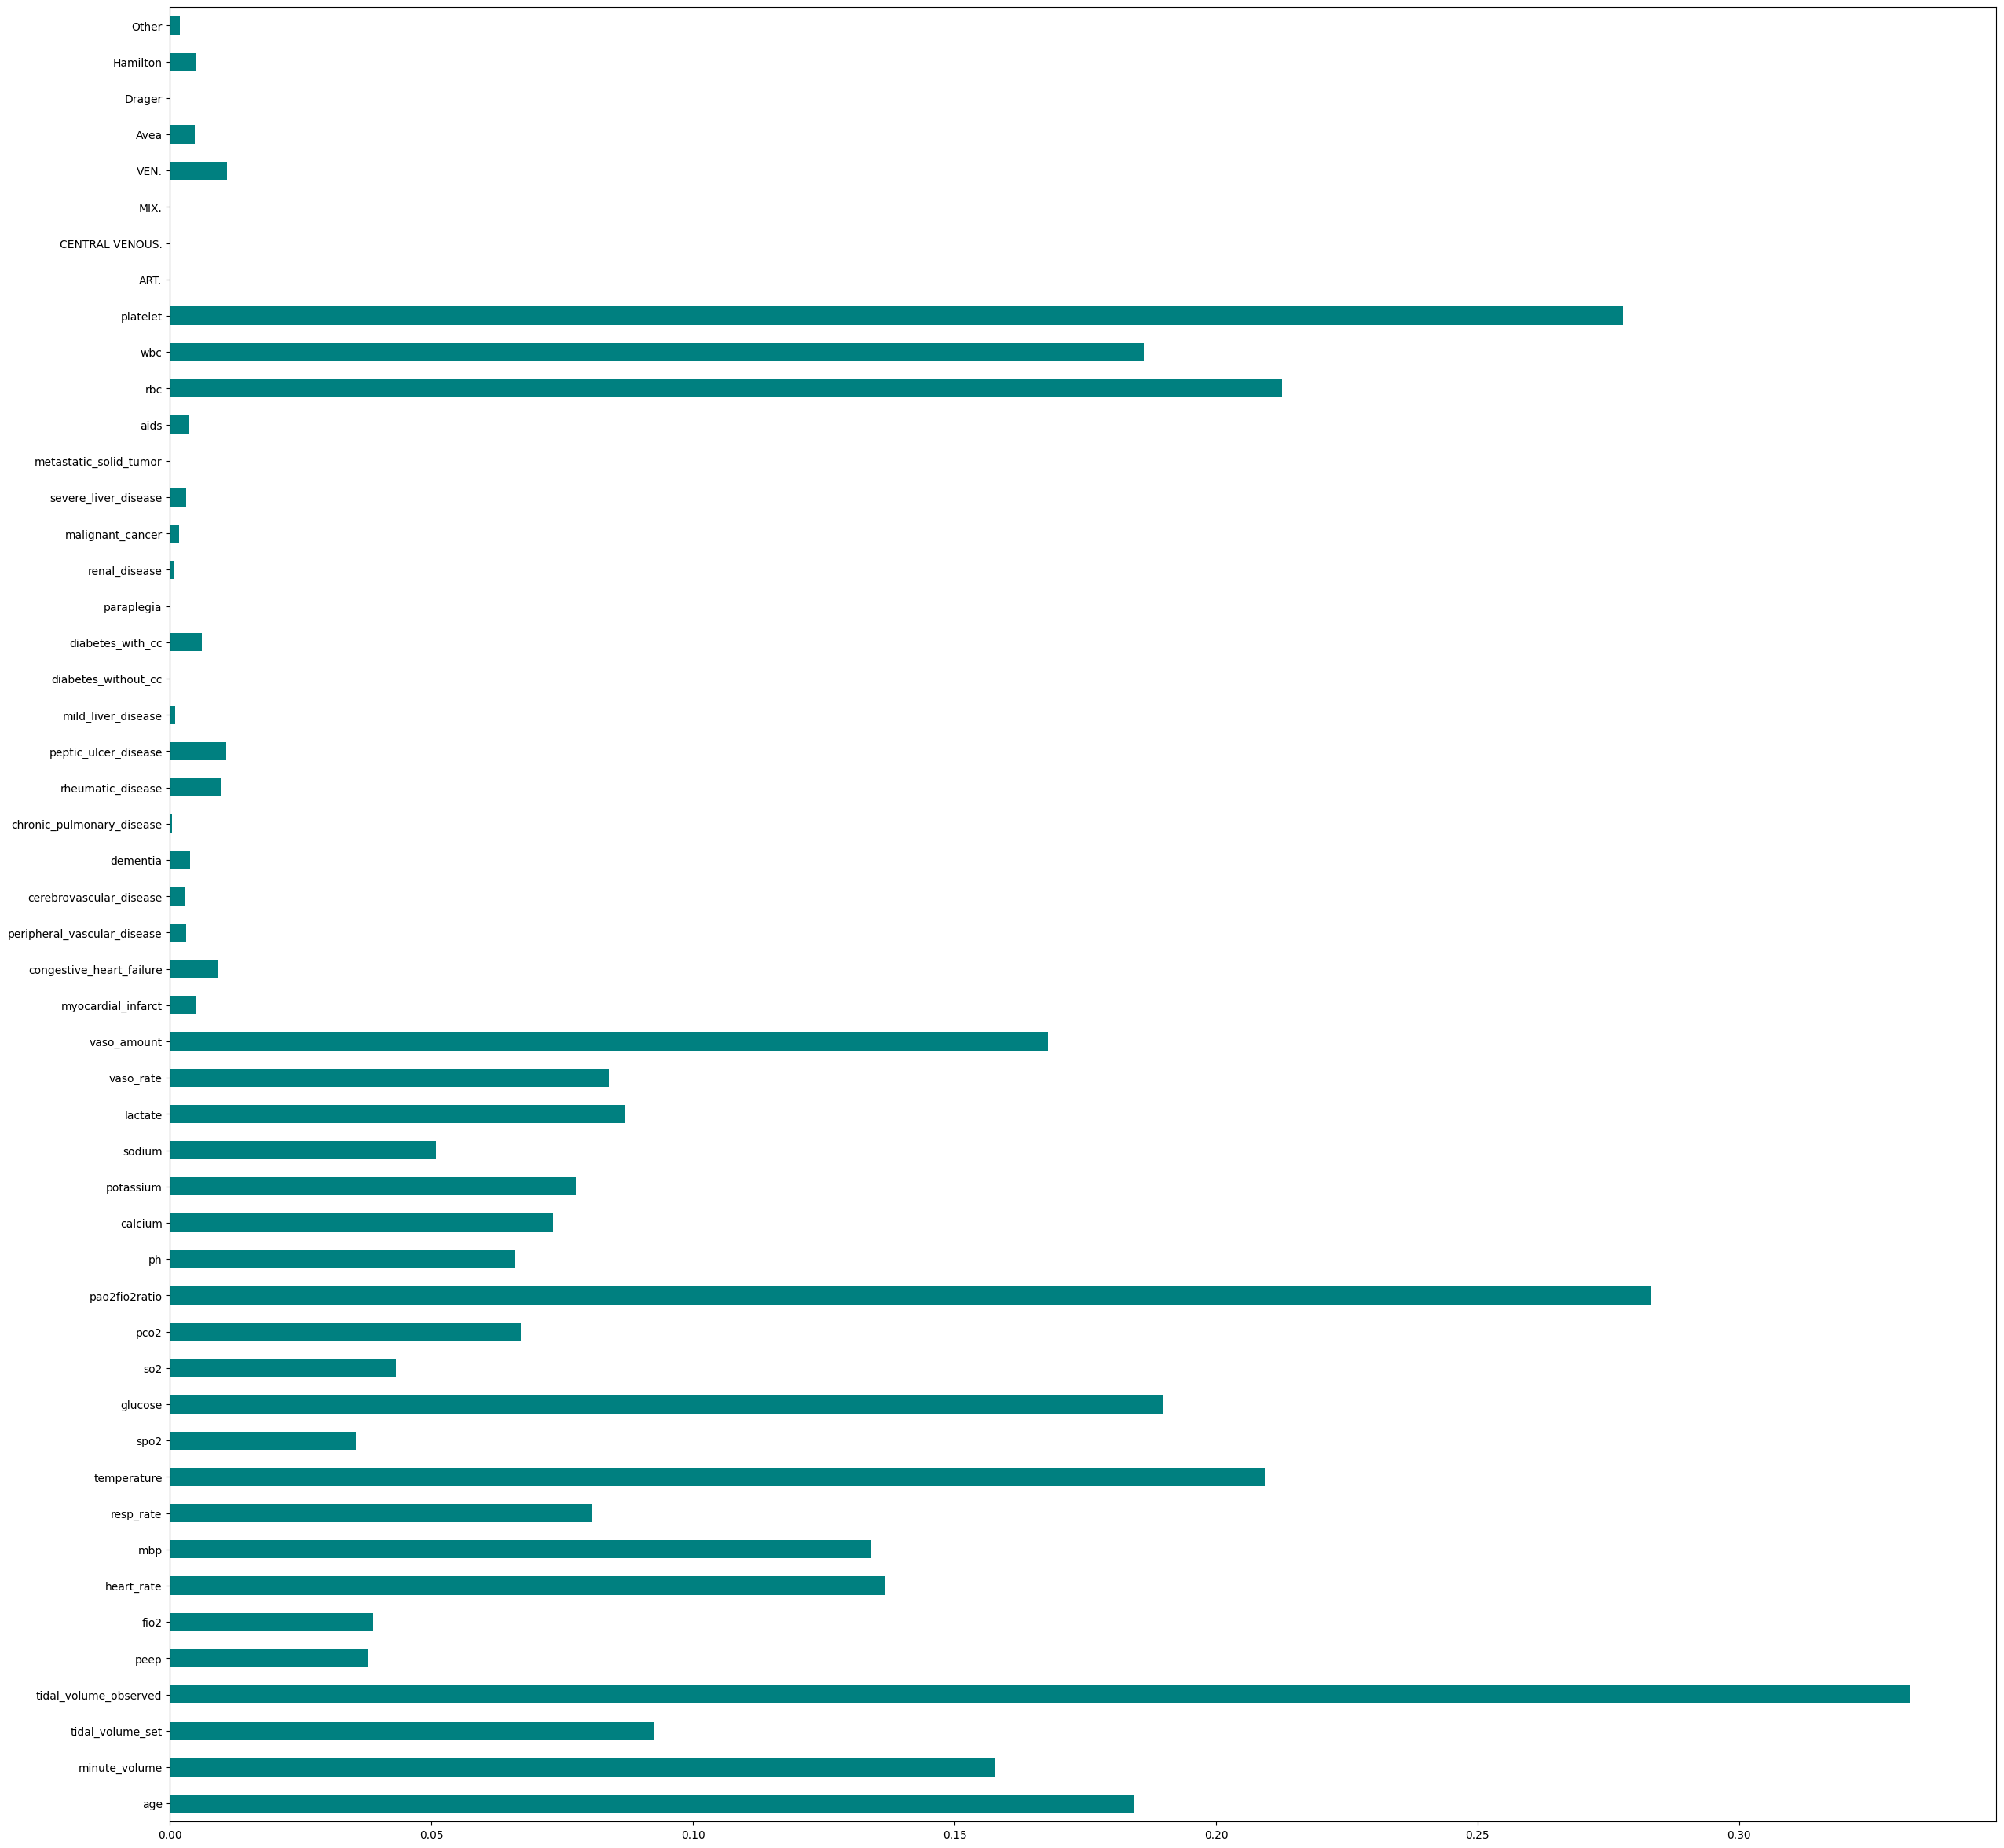

In [ ]:
feat_importances = pd.Series(importances, grouped_and_sorted[0].columns)
plt.figure(figsize=(30,30))
feat_importances.plot(kind='barh', color='teal')
plt.show()

In [ ]:
feat_importances.sort_values(ascending=False).index

Index(['tidal_volume_observed', 'pao2fio2ratio', 'platelet', 'rbc',
       'temperature', 'glucose', 'wbc', 'age', 'vaso_amount', 'minute_volume',
       'heart_rate', 'mbp', 'tidal_volume_set', 'lactate', 'vaso_rate',
       'resp_rate', 'potassium', 'calcium', 'pco2', 'ph', 'sodium', 'so2',
       'fio2', 'peep', 'spo2', 'VEN.', 'peptic_ulcer_disease',
       'rheumatic_disease', 'congestive_heart_failure', 'diabetes_with_cc',
       'Hamilton', 'myocardial_infarct', 'Avea', 'dementia', 'aids',
       'peripheral_vascular_disease', 'severe_liver_disease',
       'cerebrovascular_disease', 'Other', 'malignant_cancer',
       'mild_liver_disease', 'renal_disease', 'chronic_pulmonary_disease',
       'metastatic_solid_tumor', 'paraplegia', 'ART.', 'CENTRAL VENOUS.',
       'MIX.', 'diabetes_without_cc', 'Drager'],
      dtype='object')

In [191]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(new_X, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [192]:
y_pred = model.predict(new_X)
predictions = [round(value) for value in y_pred]

In [193]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.18%


In [194]:
new_X_t = make_normal_samples(X_test)

In [195]:
y_pred = model.predict(new_X_t)
predictions = [round(value) for value in y_pred]

In [196]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.73%


In [ ]:
new_X.shape

(11100, 50)